### Project Description

We're provided with a dataset of users and movies which shows how each user has rated some of the movies from the list. Using the sparse autoencoder, we want to build a machine learning model which will be able to predict how good it would be to recommend to a user a movie that they didn't watch. 

### The Approach

The project consists of the following steps:

1. Importing end exploring the movie ratings database
2. Categorizing the movie ratings into a recommendation classes
3. Preprocessing the data into 2D tensors containing users and movie ratings, and splitting the ratings into train and the test set
4. Building and training the autoencoder
5. Evaluating the performace on a test set, and then trying to reconstruct the whole rating data from a part of the data

### Importing the Dataset

First we'll import the necessary libraries and the ratings dataset.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ratings = pd.read_csv('./ml-1m/ratings.dat', sep = '::',
                  header = None, engine = 'python')
ratings.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
#renaming the columns for a clear interpretation
ratings.columns = ['UserID','MovieID','Rating','Timestamp']
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


We don't need the `Timestamp` column for this project, so we'll omit it. 

In [4]:
ratings = ratings.drop(columns = ['Timestamp'])
ratings.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   UserID   1000209 non-null  int64
 1   MovieID  1000209 non-null  int64
 2   Rating   1000209 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


The dataset is clean, and we can immediatly work with it. However, it would be nice to know what movie stands behind a certain ID. That's why we'll read in one more dataset, with the movie info.

In [6]:
#loading the movie info dataset
movies = pd.read_csv('./ml-1m/movies.dat', sep = '::',
                    header = None, engine = 'python')

movies.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
#renaming columns for a clear interpretation
movies.columns = ['MovieID', 'Name', 'Genre']
movies.head()

,MovieID,Name,Genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   int64 
 1   Name     3883 non-null   object
 2   Genre    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


The movies dataset is also completely clean.

### Categorizing the Ratings

Let's now check how the ratings are distributed.

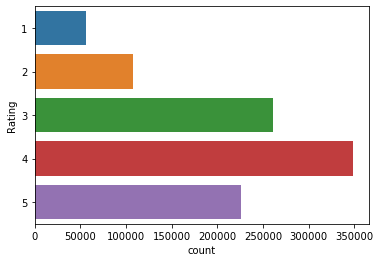

In [9]:
sns.countplot(y = 'Rating', data = ratings);

We see that 3-5 star ratings are the most common, with 4-star ratings being the predominant. 

Now we separate the ratings into three classes `good` (having 5 or 4 stars), `mediocre` (having 3 stars) and `bad` (having only 1 or 2 stars).  For the training purpose we will encode these categories as 3, 2 and 1, respectively. In the recommendation sense, we can interpret the `good` category as the movie we would most likely recommend, `mediocre` as a low-chance recommendation, and `bad` as the movies we wouldn't recommend.

In [10]:
labels = pd.cut(ratings['Rating'], bins = [0,2,3,5], 
                        labels = [1, 2, 3])

label_names = ['bad', 'mediocre', 'good']

In [11]:
ratings['Rating'] = labels
ratings = ratings.rename(columns = {'Rating' : 'Rating Category'})
ratings.head()

,UserID,MovieID,Rating Category
0,1,1193,3
1,1,661,2
2,1,914,2
3,1,3408,3
4,1,2355,3


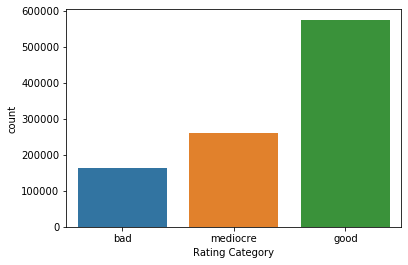

In [12]:
cplt = sns.countplot(ratings['Rating Category'])
cplt.set(xticklabels = label_names);

We see that the good ratings are significantly predominating the bad and the mediocre ones, which means that we're dealing with the imbalanced dataset. 

### Data Preprocessing

Now we need to separate our dataset into a training and test set. Even though we're building an unsupervised learning model, we will use the labels in order to stratify the separation, and thus combat the dataset imbalance.

In [13]:
X = ratings
y = labels

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X, test_size = 0.25,
                                  stratify = y, random_state = 91)

X_train.shape, X_test.shape

((750156, 3), (250053, 3))

Since we are going to build the model using PyTorch, we need to convert the data into the appropriate format, which is list of lists. Each sublist of this list represents a user, and each entry of the sublist a rating for the every movie. 

In [15]:
num_of_users = max(ratings['UserID'])
num_of_movies = max(ratings['MovieID'])
print(f'A total number of {num_of_users} users have rated a total number of {num_of_movies} movies.')

A total number of 6040 users have rated a total number of 3952 movies.


In [16]:
def convert_data(data):
    
    '''Transforms the data into a list of lists.'''

    conv_data = []

    for i in range(1, num_of_users + 1):
        rat_cat = np.zeros(num_of_movies)
        movie_ids = data[data['UserID'] == i]['MovieID']
        movie_rats = data[data['UserID'] == i]['Rating Category']

        rat_cat[movie_ids - 1] = movie_rats
        conv_data.append(rat_cat)
    
    return conv_data

In [17]:
X_train = convert_data(X_train)
X_test = convert_data(X_test)

In [18]:
#converting the list of lists into a PyTorch tensor
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [19]:
X_train.shape, X_test.shape

(torch.Size([6040, 3952]), torch.Size([6040, 3952]))

So, now we have 2D tensors (i.e. matrices) where each row corresponds to a user, and each column to a movie. The value $a_{ij}\in\{1,2,3\}$ of a given tensor means that the user $i$ has rated a movie $j$ giving it a category rating of 1, 2 or 3. If $a_{ij} = 0$, then that means that the user $i$ did not rate movie $j$. 

### Building and Training the Autoencoder

Now it's time to build our autoencoder. It consists of five layers, the outside layers representing the ratings of a user, inside layers having 20 nodes, and the middle layer having 10 nodes. We will use the `RMSprop` as the optimizer. 

In [20]:
import torch.nn as nn
import torch.optim as optim

#building the sparse autoencoder
class SAE(nn.Module):
    
    #defining the architecture of the autoencoder
    def __init__(self, ):
        super().__init__()
        #fully connected layers
        self.fc1 = nn.Linear(num_of_movies, 20)
        self.fc2 = nn.Linear(20,10)
        self.fc3 = nn.Linear(10,20)
        self.fc4 = nn.Linear(20, num_of_movies)
        #activation function
        self.activation = nn.Sigmoid()
        
    #forward propagation
    def forward(self,x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [21]:
#compiling the autoencoder
sparse_autoenc = SAE()
loss_func = nn.MSELoss()
optimizer = optim.RMSprop(sparse_autoenc.parameters(),
                         lr = 0.01, weight_decay = 0.5)

We now train the autoencoder. The training set represents just a portion of the total ratings each user has given to all the movies they have rated. By trying to reconstruct this portion of the data, the autoencoder will perform an unsupervised learning.

In [22]:
#training the auntoencoder
epochs = 200
loss_track = []


for epoch in range(epochs):
    
    train_loss = 0
    steps = 0
    
    for user_id in range(num_of_users):
        
        input_vec = X_train[user_id]
        
        if (torch.sum(input_vec) > 0) > 0:
            #generating the target and the output vectors
            target_vec = input_vec.clone()
            target_vec.requre_grad = False
            output_vec = sparse_autoenc(input_vec)
            #omitting the movies which are not rated
            output_vec[target_vec == 0] = 0
            #calculating the loss
            loss = loss_func(target_vec[target_vec > 0], output_vec[target_vec > 0])
            #calculating the gradients
            loss.backward()
            #updating the weights
            optimizer.step()
            
            train_loss += torch.sqrt(loss).data
            steps += 1
            
    loss_track.append(train_loss/steps)

In [40]:
#saving the model
torch.save(sparse_autoenc.state_dict(), 'pretrained_sae')

### Evaluating the Autoencoder

First we'll check how the loss evolved during the training of the autoencoder, and then we'll evaluate the performance on the test set.

In [ ]:
#loading the model, if needed
sparse_autoenc.load_state_dict(torch.load('pretrained_sae'))

In [23]:
#the loss in the last epoch
print(f'training loss in the last epoch: {round(float(loss_track[-1]),2)}')

training loss in the last epoch: 0.55


Since we actually have three categories of ratings/recommendations, having an average loss of 1 means that we would usually miss the missrecommend a movie by a whole clas. However, in our case we have and average loss of 0.55, which is a quite good result. This means that, in average, we will "miss a half of a class" with our autoencoder. In other words, this means that usually we will stay inside the clas, i.e. we will usually make a good recommendation.

Let's make a plot to see how the loss evolved over the trainig.

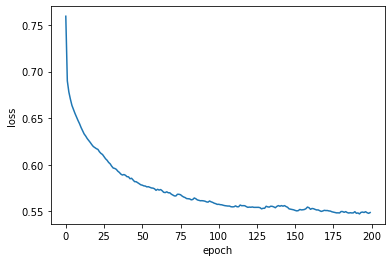

In [24]:
plt.plot(range(epochs), loss_track);
plt.xlabel('epoch');
plt.ylabel('loss');

Let's now see how the autoencoder behavies on the test set. The test set represents the portion of users' ratings not included in the training set. We will now try to reconstruct these ratings using our autoencoder. 

In [25]:
#evaluating the autoencoder on the test set

test_loss = 0
steps = 0

for user_id in range(num_of_users):

    input_vec = X_test[user_id]
    input_vec.require_grad = False
    
    if (torch.sum(input_vec) > 0) > 0:
        #generating the target and output vector
        target_vec = input_vec.clone()
        output_vec = sparse_autoenc(input_vec).data
        #omitting the movies which are not rated
        output_vec[target_vec == 0] = 0
        #calculating the loss
        loss = loss_func(target_vec[target_vec > 0], output_vec[target_vec > 0]).data
        test_loss += torch.sqrt(loss)
        steps += 1

test_loss = float(test_loss.data/steps)
print(f'test loss: {round(test_loss, 2)}')

test loss: 0.77


The average loss of 0.77 on the test set means that, again, usually we will make a good recommendation, even on the data that our autoencoder hasn't seen yet. However, the missrecomendation is somewhat more likely to occur on the new data.

In the next step we will merge the ratings data for all the users and all the (rated) movies, and try to reconstruct the whole recommendation data just from the training portion. 

In [26]:
#reconstructing the whole rating/recommendation data

reconst_loss = 0
steps = 0

for user_id in range(num_of_users):

    input_vec = X_train[user_id].data
    target_vec = (X_train[user_id] + X_test[user_id]).data
    
    if (torch.sum(target_vec) > 0) > 0:
        output_vec = sparse_autoenc(input_vec).data
        output_vec[target_vec == 0] = 0
        #calculating the loss
        loss = loss_func(target_vec[target_vec > 0], output_vec[target_vec > 0])
        reconst_loss += torch.sqrt(loss).data
        steps += 1

reconst_loss = float(reconst_loss.data/steps)
print(f'reconstruction loss: {round(reconst_loss, 2)}')

reconstruction loss: 0.61


With the loss of 0.61, we again obtain a good score. 

Now we will build a function to compute the portion of missrecommended movies for a random user.

In [27]:
def reconst_example():
    
    '''Computes the number and the 
    percentage of misses for a random user'''
    
    user_id = np.random.randint(len(X_train))
    
    input_vec = X_train[user_id].data
    target_vec = (X_train[user_id] + X_test[user_id]).data
    output_vec = sparse_autoenc(input_vec).data
    output_vec[target_vec == 0] = 0
    
    a = sum(target_vec)
    b = sum(torch.round(output_vec))
    missrate = int(abs(a-b))
    missrate_purc = missrate/X_train.shape[1]
    missrate_purc = round(missrate_purc*100, 2)
    
    print(f'Missratings for user no.{user_id}: {missrate}, {missrate_purc}%')

In [28]:
for _ in range(10):
    reconst_example()

Missratings for user no.3602: 65, 1.64%
Missratings for user no.1271: 11, 0.28%
Missratings for user no.2692: 6, 0.15%
Missratings for user no.1341: 12, 0.3%
Missratings for user no.3309: 9, 0.23%
Missratings for user no.6003: 0, 0.0%
Missratings for user no.4192: 37, 0.94%
Missratings for user no.3834: 1, 0.03%
Missratings for user no.979: 13, 0.33%
Missratings for user no.4072: 3, 0.08%


As we see, the percentage of missres is very very low, which means that we may consider our autoencoder quite reliable for giving the recommendations.

### Making Recommendations

Let's pick a random user and see wheather we would recommend them some movie they haven't watched yet. 

In [191]:
from tabulate import tabulate

X_whole = X_train + X_test
recom = ["Not Recommended", "Maybe", "Recommended"]

def recommendation():
    
    k = np.random.randint(len(X_whole))
    print(f'The user {k} liked the movies:\n')
    liked = np.random.choice(np.where(X_whole[k] == 3)[0], 5,
                            replace = False)
    like_tab = []
    for movie in liked:
        l = movies.loc[movie, ['Name', 'Genre']].tolist()
        like_tab.append([l[0],l[1]])
    print(tabulate(like_tab))
    print('..................\n')
    
    
    print("but didn't like the movies:\n")
    disl = np.where(X_whole[k] == 1)[0]
    disliked = np.random.choice(disl, min(5, len(disl)),
                            replace = False)
    disl_tab = []
    for movie in disliked:
        l = movies.loc[movie, ['Name', 'Genre']].tolist()
        disl_tab.append([l[0],l[1]])
    print(tabulate(disl_tab))
    print('..................\n')
    
    
    print("Recommendations:\n")
    unrated = np.random.choice(np.where(X_whole[k] == 0)[0], 5,
                            replace = False)
    ratings_pred = sparse_autoenc(X_whole[k]).data[unrated]
    ratings_pred = torch.round(ratings_pred)
    ratings_pred = np.array(ratings_pred, dtype = 'int8')
    rec_tab = []
    for movie, rat in zip(unrated, ratings_pred):
        l = movies.loc[movie, ['Name', 'Genre']].tolist()
        rec_tab.append([l[0], l[1], recom[rat-1]])
    print(tabulate(rec_tab))

In [195]:
recommendation()

The user 270 liked the movies:

----------------------------------  -------------------
That Thing You Do! (1996)           Comedy
Cool Hand Luke (1967)               Comedy|Drama
Even Cowgirls Get the Blues (1993)  Comedy|Romance
Creature Comforts (1990)            Animation|Comedy
Serial Mom (1994)                   Comedy|Crime|Horror
----------------------------------  -------------------
..................

but didn't like the movies:

------------------  -------------------------------
Ulee's Gold (1997)  Drama
True Lies (1994)    Action|Adventure|Comedy|Romance
Babe (1995)         Children's|Comedy|Drama
Angel Baby (1995)   Drama
Buddy (1997)        Adventure|Children's|Drama
------------------  -------------------------------
..................

Recommendations:

----------------------------  ------------------------  ---------------
Rude (1995)                   Drama                     Recommended
Mulholland Falls (1996)       Crime|Film-Noir|Thriller  Recommended
Soft Toile

### Conclusions

Using the spars autoencoder we were able to build a very reliable movie recommendation system based on previosly rated movies. In addition to being very effective, our model has very simple architecture and was trained in a reasonable time. 